`INTRODUCTION`\
This analysis is about finding the cannibalization between products within the same categories and stores. The cannibalization occurs when a product (cannibal) increases its revenue during its promotion duration, which makes sales decreases for other products (victims) in the same category.

To summarize this analysis, primary support for the flow is from the journal named `Causal Quantification of Cannibalization During Promotional Sales in Grocery Retail` (CARLOS AGUILAR-PALACIOS et al., 2021). The helpful Python functions are also based on the journal, and there are some adjustments to be fit with this analysis.\
The two main algorithms used in this analysis, `STL decomposition` and `Causal Impact`, are referred to in their Python package tutorials:
- `STL decomposition`: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
- `Causal Impact`: https://pypi.org/project/pycausalimpact/

### `STAGE 1`: Import relevant packages 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import io
import warnings
warnings.filterwarnings("ignore")

from pandas import Timestamp
from pyvis.network import Network
from tqdm import tqdm
from zipfile import ZipFile
from utils import (
    decompose_signal, 
    compare_promo_regular_sales, 
    calculate_causal_impact_with_covariates, 
    split_promos_into_sequences
)

### `STAGE 2`: Read & Transform data 

In [2]:
# read dimension data
product_hierarchy = pd.read_csv('./data/product_hierarchy.csv')
store_cities = pd.read_csv('./data/store_cities.csv')

# read fact data
sales_zip = ZipFile('./data/sales.csv.zip', 'r')
sales_data = sales_zip.read('sales.csv')
sales_bytes = io.BytesIO(sales_data)
sales_bytes.seek(0)
sales = pd.read_csv(sales_bytes, converters={'promo_bin_1':str,'promo_bin_2':str,'promo_discount_type_2':str})

df = sales.query("sales != 0 and ~sales.isnull()").reset_index(drop=True) # remove null or no sales lines
df["date"] = pd.to_datetime(df["date"]) # convert to datetime format
df['promo'] = df[['promo_bin_1','promo_bin_2']].sum(axis=1) != '' # assume that product is in promotion when it is involved in promotion bin 1 or promotion bin 2

df_sales = df.reindex(columns=['product_id', 'store_id', 'date', 'revenue', 'promo']) # pick only columns in need, to reduce the data size in memory

- There are `144` stores serving `629` products to customers. The sales data limits date range from 2017-01-02 to 2019-10-31 (1033 days in total).
- `529` products used to be in promotion.
- All stores sell at least one product in promotion.
- Nearly `120` stores are mature when serving their customers over 900 days

In [3]:
# describe the sales data
df_sales.describe(include=["object","datetime"])

,product_id,store_id,date
count,3189682,3189682,3189682
unique,629,144,1033
top,P0103,S0085,2018-06-14 00:00:00
freq,114022,92706,4316
first,NaN,NaN,2017-01-02 00:00:00
last,NaN,NaN,2019-10-31 00:00:00


In [4]:
# get to know how many products are in promotion
df_sales.groupby("product_id")["promo"].max().value_counts()

True     529
False    100
Name: promo, dtype: int64

In [5]:
# get to know how many stores sells products in promotion
df_sales.groupby("store_id")["promo"].max().value_counts()

True    144
Name: promo, dtype: int64

<AxesSubplot: >

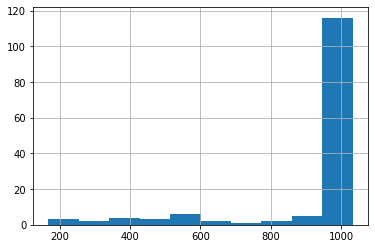

In [6]:
# calculate total revenue by store per day
df_sales_daily = df_sales.groupby(["store_id","date"]).agg(total_revenue=("revenue","sum"))
# number of sales days by store
df_sales_daily.reset_index().groupby("store_id")["date"].count().hist()

Define initial parameters

In [7]:
# make the list of hex colors
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

# assume that revenue is 7-day periodical and at peak during the weekends
period_in_days = 7

# set the low limit for trend component. If the trend component is lower than this limit, the product is not available in this day.
minimum_heartbeat = 0.85

# Fig sizes
fig_h = 10/1.5
fig_w = 18/1.5

 # assign ci analysis result path
ci_analysis_result_path = './data/ci_analysis_results.csv'

# if `True`, the whole process from pivoting data to the end will be rerun.
analysis_rerun = False 

### `STAGE 3`: Decomposition

> Seasonal-Trend decomposition using LOESS (STL) splits a time series into 3 parts: seasonal, trend, and residual. The seasonal component is calculated first, and then subtracted to estimate the trend component. The remaining part from the actual and two first components is the residual.\
More details about STL can be found in the link below: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

STL is chosen in this analysis for removing possible outliers in sales time series. This action is critical due to the lack of knowledge about business strategies from the company that the dataset mentions. No unit of a product sold in a day is not made sure to make a conclusion that the customers ignore it. Out-of-stock, holidays, culture-related behaviors...can prevent customers from products. Therefore, STL help fulfill the day with outliers (e.g. unusual lack of sales in some days) based on the trend and seasonal components.\
The sales data is supposed to be at peak on the weekends, which means the customers tend to buy on the weekends more than the weekdays.

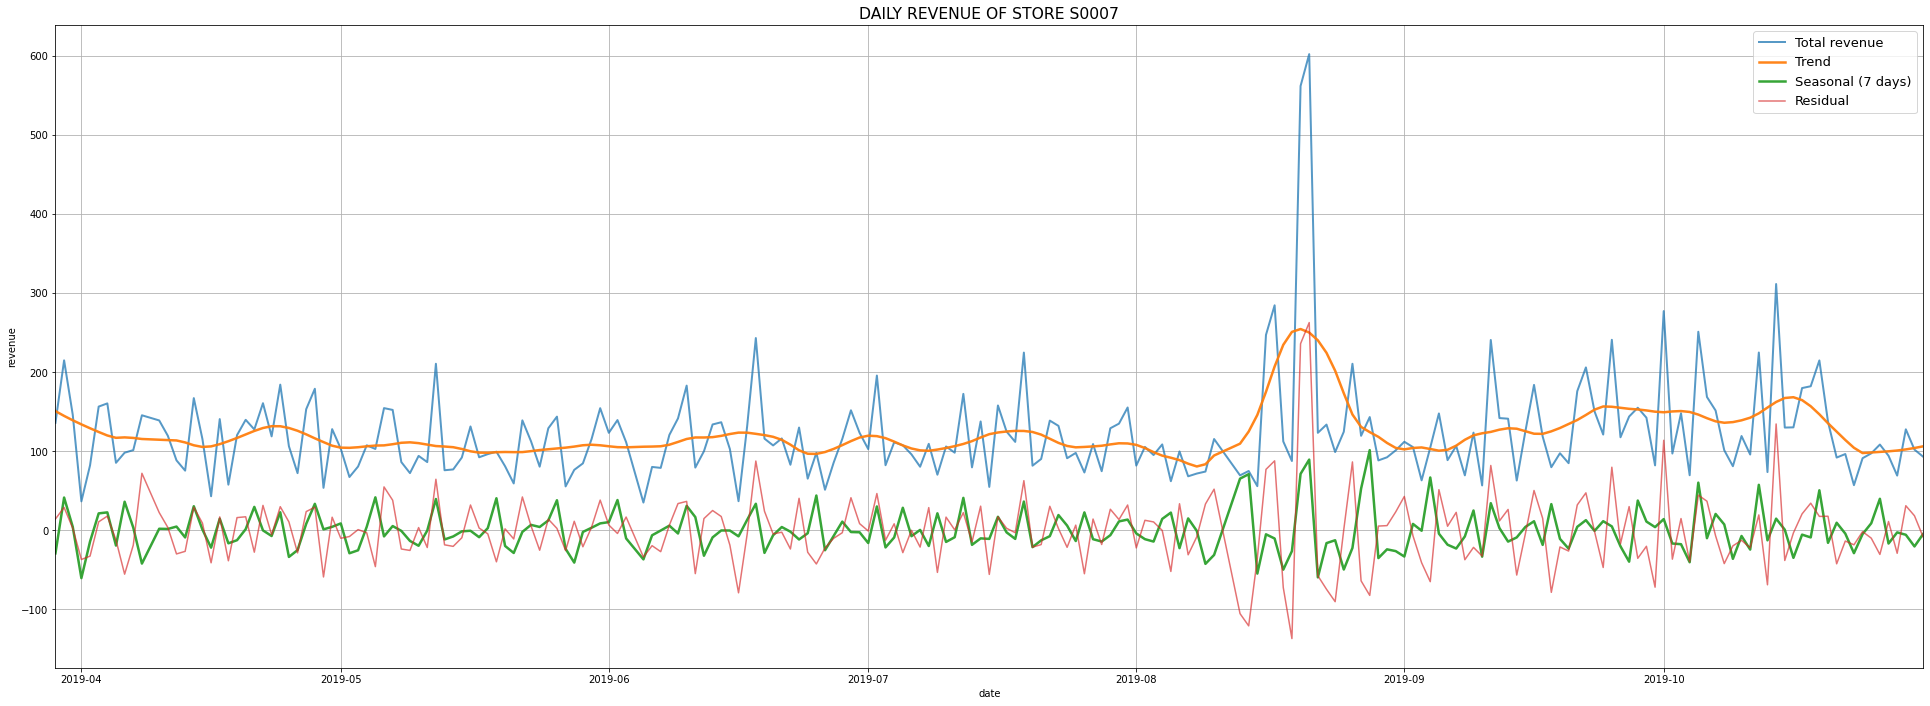

In [8]:
# use store S0007 as a sample for the sales decomposition using LOESS
df_sales_S0007 = df_sales_daily[(df_sales_daily.index.get_level_values(0)=="S0007")]
df_sales_S0007_daily = df_sales_S0007.reset_index(level=0)["total_revenue"]

fig, ax = plt.subplots(1,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))
font_size = 13
plt.rcParams.update({'font.size': font_size})

x_axis = df_sales_S0007_daily.index

decomposition_results = decompose_signal(df_sales_S0007_daily, period_in_days=period_in_days)
df_decomposition = pd.DataFrame(decomposition_results)

idx_store = 0

ax.plot(x_axis, df_sales_S0007_daily, label=f'Total revenue', color=def_colours[idx_store], linewidth=1+1, alpha=0.75)

ax.plot(x_axis, df_decomposition['trend'], label=f'Trend', color=def_colours[idx_store+1], linewidth=1.5+1, alpha=0.95)

ax.plot(x_axis, df_decomposition['seasonal'], label=f'Seasonal ({period_in_days} days)', color=def_colours[idx_store+2], linewidth=1.5+1, alpha=0.95)

ax.plot(x_axis, df_decomposition['residual'], label=f'Residual', color=def_colours[idx_store+3], linewidth=0.5+1, alpha=0.65)


plt.legend()
plt.xlabel('date')
plt.ylabel('revenue')
plt.title("DAILY REVENUE OF STORE S0007")
plt.grid(True)
plt.tight_layout()
plt.margins(0,0.05)


We should transform the actual revenue and its decomposition components to tables as `store_id` and `date` in row headers, `product_id` in column headers. Then, we fill all null cells with `zero` or `False`.\
This action makes sure every single product appears in every sales date, despite no unit.

In [32]:
# due to the large dataset, to time-saving for further reruns, if analysis results have been saved, it is reused.
if os.path.exists(path=ci_analysis_result_path):
    df_CI_analysis = pd.read_csv(ci_analysis_result_path)
    df_CI_analysis[["idx_regular_days","idx_promo_days"]] = df_CI_analysis[["idx_regular_days","idx_promo_days"]].applymap(lambda x: eval(x))
else:
    df_CI_analysis = pd.DataFrame()

total_product_list = df_sales["product_id"].unique().tolist()
if analysis_rerun or df_CI_analysis.shape == (0,0):
    product_list = total_product_list
else:
    product_list = pd.concat([df_CI_analysis["product_id_A"], df_CI_analysis["product_id_B"]]).unique().tolist()

print("number of focused products:", len(product_list), '/' , len(total_product_list))

number of focused products: 355 / 629


In [10]:
# pivot the actual revenue
df_sales_pivot = df_sales[df_sales["product_id"].isin(product_list)].pivot(index=["store_id","date"], columns="product_id", values="revenue")
df_sales_pivot.fillna(0, inplace=True)
df_sales_pivot = df_sales_pivot.merge(df_sales_daily, left_index=True, right_index=True)
df_sales_pivot.head()

P0001  P0005  P0007  P0008  P0011  P0012  P0014  P0015  \
store_id date                                                                 
S0001    2017-01-02    0.0    0.0    0.0    0.0    0.0    0.0    0.0   2.41   
         2017-01-03    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.00   
         2017-01-04    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.00   
         2017-01-05    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.00   
         2017-01-06    0.0    0.0    0.0    0.0    0.0    0.0    0.0   9.26   

                     P0017  P0018  ...  P0732  P0733  P0735  P0737  P0739  \
store_id date                      ...                                      
S0001    2017-01-02   0.00    0.0  ...    0.0    0.0   0.00    0.0    0.0   
         2017-01-03   0.00    0.0  ...    0.0    0.0   0.00    0.0    0.0   
         2017-01-04   1.38    0.0  ...    0.0    0.0  14.41    0.0    0.0   
         2017-01-05   0.00    0.0  ...    0.0    0.0   7.20    0.0    0.0   
         2017-01-06   0.00    0.0  ...    0.0    0.0   0.00    0.0    0.0   

                     P0740  P0741  P0747  P0748  total_revenue  
store_id date                                                   
S0001    2017-01-02    0.0    0.0    0.0    0.0         187.86  
         2017-01-03    0.0    0.0    0.0    0.0         211.56  
         2017-01-04    0.0    0.0    0.0    0.0         297.27  
         2017-01-05    0.0    0.0    0.0    0.0         336.01  
         2017-01-06    0.0    0.0    0.0    0.0         199.90  

[5 rows x 356 columns]

In [11]:
# pivot the actual promotion check
df_promotion_pivot = df_sales.pivot(index=["store_id","date"], columns="product_id", values="promo")
df_promotion_pivot.fillna(False, inplace=True)
df_promotion_pivot.head()

product_id           P0001  P0002  P0004  P0005  P0006  P0007  P0008  P0009  \
store_id date                                                                 
S0001    2017-01-02  False  False  False  False  False  False  False  False   
         2017-01-03  False  False  False  False  False  False  False  False   
         2017-01-04  False  False  False  False  False  False  False  False   
         2017-01-05  False  False  False  False  False  False  False  False   
         2017-01-06  False  False  False  False  False  False  False  False   

product_id           P0010  P0011  ...  P0737  P0738  P0739  P0740  P0741  \
store_id date                      ...                                      
S0001    2017-01-02  False  False  ...  False  False  False  False  False   
         2017-01-03  False  False  ...  False  False  False  False  False   
         2017-01-04  False  False  ...  False  False  False  False  False   
         2017-01-05  False  False  ...  False  False  False  False  False   
         2017-01-06  False  False  ...  False  False  False  False  False   

product_id           P0742  P0745  P0746  P0747  P0748  
store_id date                                           
S0001    2017-01-02  False  False  False  False  False  
         2017-01-03  False  False  False  False  False  
         2017-01-04  False  False  False  False  False  
         2017-01-05  False  False  False  False  False  
         2017-01-06  False  False  False  False  False  

[5 rows x 629 columns]

In [12]:
# pivot the trend component
df_trend_pivot = pd.DataFrame(index=df_sales_pivot.index)

# Season-Trend decomposition using LOESS
for product_A in tqdm(product_list):
    trend = df_sales_pivot.groupby(level=0)[product_A].transform(lambda series: decompose_signal(series, period_in_days=period_in_days)['trend'])
    df_trend_pivot = pd.concat([df_trend_pivot, trend], axis=1)

df_trend_pivot.head()

  0%|          | 0/355 [00:00<?, ?it/s]

100%|██████████| 355/355 [09:10<00:00,  1.55s/it]


In [17]:
# create the heartbeat flag table
df_heartbeat_flag = df_trend_pivot > minimum_heartbeat
df_heartbeat_flag.head()

P0316  P0305  P0559  P0390  P0681  P0730  P0340  P0102  \
store_id date                                                                 
S0001    2017-01-02  False  False  False  False   True  False  False  False   
         2017-01-03  False  False  False  False   True  False  False  False   
         2017-01-04  False  False  False  False   True  False  False  False   
         2017-01-05  False  False  False  False   True  False  False  False   
         2017-01-06  False  False  False  False   True  False   True  False   

                     P0130  P0679  ...  P0616  P0678  P0696  P0673  P0448  \
store_id date                      ...                                      
S0001    2017-01-02  False  False  ...  False  False  False   True  False   
         2017-01-03  False  False  ...  False  False  False   True  False   
         2017-01-04  False  False  ...  False  False  False   True  False   
         2017-01-05  False  False  ...  False  False  False   True  False   
         2017-01-06  False  False  ...  False  False  False   True  False   

                     P0321  P0126  P0594  P0583  P0266  
store_id date                                           
S0001    2017-01-02   True  False  False  False  False  
         2017-01-03   True  False  False  False  False  
         2017-01-04   True  False  False  False  False  
         2017-01-05   True  False  False  False  False  
         2017-01-06   True  False  False  False  False  

[5 rows x 355 columns]

In [18]:
# pivot the residual component
df_residual_pivot = pd.DataFrame(index=df_sales_pivot.index)

# Season-Trend decomposition using LOESS
for product_A in tqdm(product_list):
    residual = df_sales_pivot.groupby(level=0)[product_A].transform(lambda series: decompose_signal(series, period_in_days=period_in_days)['residual'])
    df_residual_pivot = pd.concat([df_residual_pivot, residual], axis=1)

df_residual_pivot.head()

100%|██████████| 355/355 [08:51<00:00,  1.50s/it]


P0316  P0305  P0559     P0390     P0681  P0730  \
store_id date                                                            
S0001    2017-01-02 -0.000817    0.0    0.0  0.213421 -0.636251    0.0   
         2017-01-03 -0.000455    0.0    0.0 -1.337168 -0.633595    0.0   
         2017-01-04  0.000042    0.0    0.0  0.606652  0.041771    0.0   
         2017-01-05  0.000355    0.0    0.0  0.278808  1.584871    0.0   
         2017-01-06  0.000896    0.0    0.0  0.340916  0.439865    0.0   

                        P0340  P0102     P0130     P0679  ...  P0616  P0678  \
store_id date                                             ...                 
S0001    2017-01-02 -7.422773    0.0 -0.000234  0.010946  ...    0.0    0.0   
         2017-01-03  2.160543    0.0  0.000763 -0.033714  ...    0.0    0.0   
         2017-01-04  1.657356    0.0  0.001210 -0.095832  ...    0.0    0.0   
         2017-01-05  2.178327    0.0  0.000588 -0.157492  ...    0.0    0.0   
         2017-01-06  0.445233    0.0 -0.000736 -0.204574  ...    0.0    0.0   

                     P0696     P0673     P0448     P0321  P0126  P0594  P0583  \
store_id date                                                                   
S0001    2017-01-02    0.0 -1.015081 -0.393944  0.577881    0.0    0.0    0.0   
         2017-01-03    0.0 -1.257627 -0.424992 -2.788858    0.0    0.0    0.0   
         2017-01-04    0.0  4.472325  0.046648  0.463189    0.0    0.0    0.0   
         2017-01-05    0.0 -1.090199 -0.434051  3.431504    0.0    0.0    0.0   
         2017-01-06    0.0 -0.708087  1.271514  0.240834    0.0    0.0    0.0   

                     P0266  
store_id date               
S0001    2017-01-02    0.0  
         2017-01-03    0.0  
         2017-01-04    0.0  
         2017-01-05    0.0  
         2017-01-06    0.0  

[5 rows x 355 columns]

### `STAGE 4`: POTENTIAL Cannibals
The two following steps will detect POTENTIAL cannibals.

In [19]:
# List of products
sku_analysis = []

# the cannibals need to be in promotion for at least consecutive `min_promo_days` days. And, in at least `min_regular_days` days before or after promotion, the cannibals are not in promotion.
min_promo_days=5
min_regular_days=10

# this array of holidays will affect on the product availability. In this case, we assume that there is no holiday effect.
holidays = pd.Series([]).astype("datetime64[ns]")

for product_A in tqdm(product_list):

    temp1 = pd.concat([
            df_sales_pivot[[product_A]].rename(columns={product_A:"revenue"}), 
            df_promotion_pivot[[product_A]].rename(columns={product_A:"promo"}), 
            df_heartbeat_flag[[product_A]].rename(columns={product_A:"heartbeat"})
        ], axis=1)
    
    for store_id, temp2 in temp1.groupby(level=0):
        
        idx_holiday_to_exclude = temp2.index.get_level_values(1).isin(holidays)
        product_behaviour = compare_promo_regular_sales(
            sales=temp2["revenue"], 
            promo=temp2["promo"],
            inferred_availability=temp2["heartbeat"],
            idx_holiday_to_exclude=idx_holiday_to_exclude,
            min_promo_days=min_promo_days, 
            min_regular_days=min_regular_days
        )

        if product_behaviour != []:
            temp3 = product_behaviour[0]
            temp3["product_id"] = product_A
            temp3["store_id"] = store_id
            sku_analysis.append(temp3)
            
    
# Stick the dicts into a DF
df_snap_stats = pd.DataFrame(sku_analysis)
df_snap_stats.set_index(["store_id","product_id"], inplace=True)
# clean the empty dictionaries
idx_nonsense = df_snap_stats.num_promo_slots.isna() | (df_snap_stats.num_promo_slots < 1)
df_snap_stats = df_snap_stats[~idx_nonsense].copy()

# for backwards compatibility
df_snap_stats['mu_difference'] = df_snap_stats['difference_averages_promo_to_regular']
# Add a small offset to avoid 0-divisions
df_snap_stats['mu_delta'] = df_snap_stats.apply(lambda snap_reg: (snap_reg['avg_promo_sales']+0.01)/(snap_reg['avg_regular_sales']+0.01), axis=1)

# descendingly sort mu_delta
df_snap_stats.sort_values(by=['mu_delta'], ascending=False, inplace=True)

df_snap_stats.head()

100%|██████████| 355/355 [10:33<00:00,  1.78s/it]


,,num_promo_slots,avg_promo_sales,avg_regular_sales,promo_days,regular_days,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta
store_id,product_id,,,,,,,,,,,,
S0051,P0316,1,229.920,0.0,28.0,136.0,229.920,6437.76,[229.92000000000002],[0.0],0.533915,229.920,22993.0
S0108,P0102,1,211.360,0.0,5.0,472.0,211.360,1056.80,[211.35999999999999],[0.0],0.019380,211.360,21137.0
S0056,P0471,1,134.558,0.0,5.0,31.0,134.558,672.79,[134.558],[0.0],0.109496,134.558,13456.8
S0062,P0058,1,125.336,0.0,20.0,501.0,125.336,2506.72,[125.33599999999998],[0.0],0.097868,125.336,12534.6
S0026,P0539,1,120.036,0.0,5.0,472.0,120.036,600.18,[120.03600000000002],[0.0],0.277132,120.036,12004.6


In [20]:
# Potential cannibals
# This threshold is used to detect uplifters based on the difference in average sales
sales_threshold = 1/3
# min AVG sales to be considered
min_avg_sales = 2

# A bit of work on the uplifters
# Snap sales greater than the sales + threshold
idx_A = df_snap_stats['mu_delta']>=(1+sales_threshold)

# Comparison only valid if they are not zero sales
idx_B = (df_snap_stats['avg_promo_sales'] > min_avg_sales) & (df_snap_stats['avg_regular_sales'] > min_avg_sales)
df_snap_stats['uplift_in_median'] = (idx_A & idx_B)

# Get two groups: potential cannibals (and haloers) and victims
df_snap_uplifters = df_snap_stats[df_snap_stats['uplift_in_median']].copy()

df_snap_uplifters.head()

,,num_promo_slots,avg_promo_sales,avg_regular_sales,promo_days,regular_days,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta,uplift_in_median
store_id,product_id,,,,,,,,,,,,,
S0020,P0316,3,466.846571,3.991720,70.0,808.0,462.854851,29453.95,"[442.5403571428572, 549.1957142857143, 350.760...","[0.0, 7.66370820668693, 2.0523323615160347]",0.261882,462.854851,116.663969,True
S0051,P0305,1,835.722857,10.555714,14.0,14.0,825.167143,11552.34,[835.7228571428574],[10.555714285714286],0.393411,825.167143,79.098567,True
S0094,P0559,1,463.444000,6.392285,10.0,1011.0,457.051715,-1828.16,[463.4440000000001],[6.392284866468843],0.062016,457.051715,72.388844,True
S0040,P0390,1,137.251667,2.427288,6.0,59.0,134.824379,680.30,[137.25166666666667],[2.4272881355932205],0.712900,134.824379,56.317374,True
S0031,P0439,1,119.196000,2.179735,10.0,189.0,117.016265,779.99,[119.196],[2.1797354497354497],0.524733,117.016265,54.438540,True


### `STAGE 5`: Victims for POTENTIAL cannibals
This action finds victims for potential cannibals, using Causal Impact analysis.

In [24]:
# If true, use the sales without the weekly pattern
do_decomposition = False

# This is the minimum bump between regular and promo
# and promo back to regular *0.25
min_diff_in_units_from_reg_to_promo = 2

# values for the CI analysis
min_ratio_change = 0.4
do_exclude_promos_SKU_B = True
# This flag is pretty good for debugging/development
be_verbose = False

# Option to deseasonalise
sku_potential_cannibals = df_snap_uplifters.index.tolist()

total_cannibals = len(sku_potential_cannibals)

if analysis_rerun or df_CI_analysis.shape == (0,0):
    for idx, dimension in enumerate(sku_potential_cannibals):

        store_id, product_A = dimension
        print(f'{idx}/{total_cannibals}:{store_id}-{product_A}')

        df_promotion_sub = df_promotion_pivot[df_promotion_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
        df_heartbeat_sub = df_heartbeat_flag[df_heartbeat_flag.index.get_level_values(0)==store_id].reset_index(level=0)
        df_sales_sub = df_sales_pivot[df_sales_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
        df_trend_sub = df_trend_pivot[df_trend_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
        df_residual_sub = df_residual_pivot[df_residual_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
        idx_holiday_to_exclude = df_sales_sub.index.isin(holidays)

        # Get the promotions and split them into slots
        promo_sku_A = df_promotion_sub[product_A]
        idx_pre_intervention, idx_post_intervention = split_promos_into_sequences(promo_sku_A, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

        availability_sku_A = df_heartbeat_sub[product_A]
        availability_value_sku_A = availability_sku_A.sum()/len(availability_sku_A)
        flag_min_availability_sku_A = availability_value_sku_A > 0.9

        # TO-DO: Decomposition should be done according to the SKU's patterns
        if flag_min_availability_sku_A & do_decomposition:
            sales_sku_A = df_trend_sub[product_A] + df_residual_sub[product_A]
        else:
            sales_sku_A = df_sales_sub[product_A]


        # go through all the SKUs in the store
        sku_potential_victims = product_list.copy()
        category_A = product_hierarchy[product_hierarchy["product_id"]==product_A]["hierarchy1_id"].iloc[0]
        sku_potential_victims = product_hierarchy[
            (product_hierarchy["hierarchy1_id"]==category_A)&       # cannibalization should be only considered when products are in the same category
            (product_hierarchy["product_id"]!=product_A)&           # product B must be different from product A
            (product_hierarchy["product_id"].isin(product_list))    # product B must have revenue
        ]["product_id"].tolist()

        for product_B in sku_potential_victims:
            availability_sku_B = df_heartbeat_sub[product_B]
            promo_sku_B = df_promotion_sub[product_B]

            # Decide what to do with sku_B on promo
            # - Remove the promo days? when? outside the cannibalisation window?
            # - We should compare windows of pre/post promo, not the entire year
            availability_value_sku_B = availability_sku_B.sum()/len(availability_sku_B)
            flag_min_availability_sku_B = availability_value_sku_B > 0.9

            if flag_min_availability_sku_B & do_decomposition:
                sales_sku_B = df_residual_sub[product_B] + df_trend_sub[product_B]
            else:
                sales_sku_B = df_sales_sub[product_B]
            
            ci_analysis = calculate_causal_impact_with_covariates(
                    promo_sku_A=promo_sku_A,
                    availability_sku_A=availability_sku_A,
                    sales_sku_B=sales_sku_B, 
                    promo_sku_B=promo_sku_B,
                    availability_sku_B=availability_sku_B,
                    idx_pre_intervention=idx_pre_intervention,
                    idx_post_intervention=idx_post_intervention,
                    idx_holiday_to_exclude=idx_holiday_to_exclude,
                    min_diff_in_units_from_reg_to_promo=min_diff_in_units_from_reg_to_promo,
                    min_ratio_change=min_ratio_change,
                    do_exclude_promos_SKU_B=do_exclude_promos_SKU_B,
                    be_verbose=be_verbose,
                    min_overlapping_days_promo=min_promo_days,
                    min_overlapping_days_regular=min_regular_days
                )
            if ci_analysis != []:
                print(f">>> {product_B}")
                causal_impact_analysis = pd.DataFrame(ci_analysis)
                causal_impact_analysis[["store_id","product_id_A","product_id_B"]] = store_id, product_A, product_B
                df_CI_analysis = pd.concat([df_CI_analysis, causal_impact_analysis])

    # save CI analysis results for further reuse
    df_CI_analysis.to_csv("./data/ci_analysis_results.csv", index=False)

do some descriptive statistics about the CI analysis result

In [38]:
# there are 6843 cannibalization cases, which appear in 128 stores, 147 cannibals and 345 victims, with the probability of greater than or equal to 50%
print(df_CI_analysis.shape)
print(df_CI_analysis[["store_id","product_id_A","product_id_B"]].nunique())

(6843, 21)
store_id        128
product_id_A    147
product_id_B    345
dtype: int64


<AxesSubplot: >

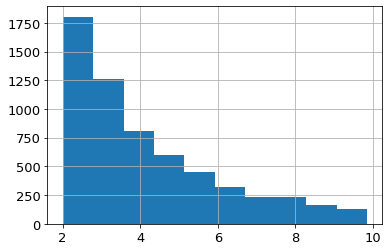

In [44]:
# victims revenue during the cannibal's promotion must decrease
# in the following histogram, in the most of cannibalization cases, the victim's revenue decrease volumne is arround 2 and 3
df_CI_analysis.diff_in_units_from_reg_to_promo.sort_values().head(6000).hist()

<AxesSubplot: >

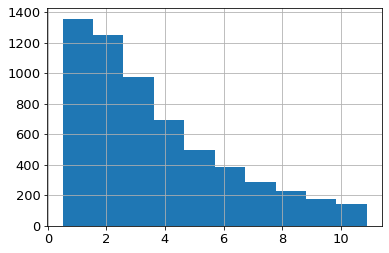

In [44]:
# victims revenue after the cannibal's promotion must return to increase
# in the following histogram, in the most of cannibalization cases, the victim's revenue increase volumne is arround 1 and 2
df_CI_analysis.diff_in_units_from_promo_to_pos_promo.abs().sort_values().head(6000).hist()

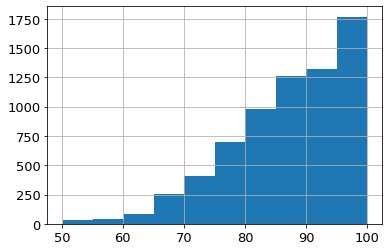

In [82]:
# the higher probability of causal impact, the higher the confidence of cannibalization
# in the following histogram, many cases get the probability over 90%
df_CI_analysis.prob_causal_effect.hist()

min_prob = 90.0

Text(0, 0.5, 'diff_from_promo_to_pos_promo')

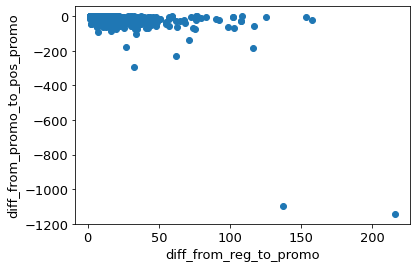

In [83]:
# for more details about how cannibals make influence on victims, try finding a specific cannibalization case,
# which has the significant impact with the higher 90% probability
# in the scatter plot, there are some cases having victim's revenue increase volumne after cannibal's promotion over 200 units, and the decrease volumne within cannibal's promotion over 50 units
plt.scatter(x=df_CI_analysis.query(f"prob_causal_effect >= {min_prob}")["diff_in_units_from_reg_to_promo"], y=df_CI_analysis.query("prob_causal_effect >= 90")["diff_in_units_from_promo_to_pos_promo"])
plt.xlabel("diff_from_reg_to_promo")
plt.ylabel("diff_from_promo_to_pos_promo")

In [85]:
# this is the sugested case
df_CI_analysis[
    (df_CI_analysis["prob_causal_effect"] >= min_prob) &
    (df_CI_analysis["diff_in_units_from_promo_to_pos_promo"] <= -200) & 
    (df_CI_analysis["diff_in_units_from_reg_to_promo"] >= 50) & 
    (df_CI_analysis["diff_in_units_from_reg_to_promo"] < 100)
].sort_values("total_overlapping_days_promo", ascending=False).iloc[0]

slot_number                                                                       9
idx_regular_days                         [2018-06-07 00:00:00, 2018-09-12 00:00:00]
idx_promo_days                           [2018-09-13 00:00:00, 2018-09-18 00:00:00]
total_overlapping_days_regular                                                   83
regular_to_promo_gap                                                              0
total_overlapping_days_promo                                                      6
competing_promo_days                                                              0
sku_B_regular_avg_sales                                                   69.078795
sku_B_avg_sales_during_promo_sku_A                                            6.945
diff_in_units_from_reg_to_promo                                           62.133795
diff_in_units_from_promo_to_pos_promo                                      -231.243
ratio_change                                                               0

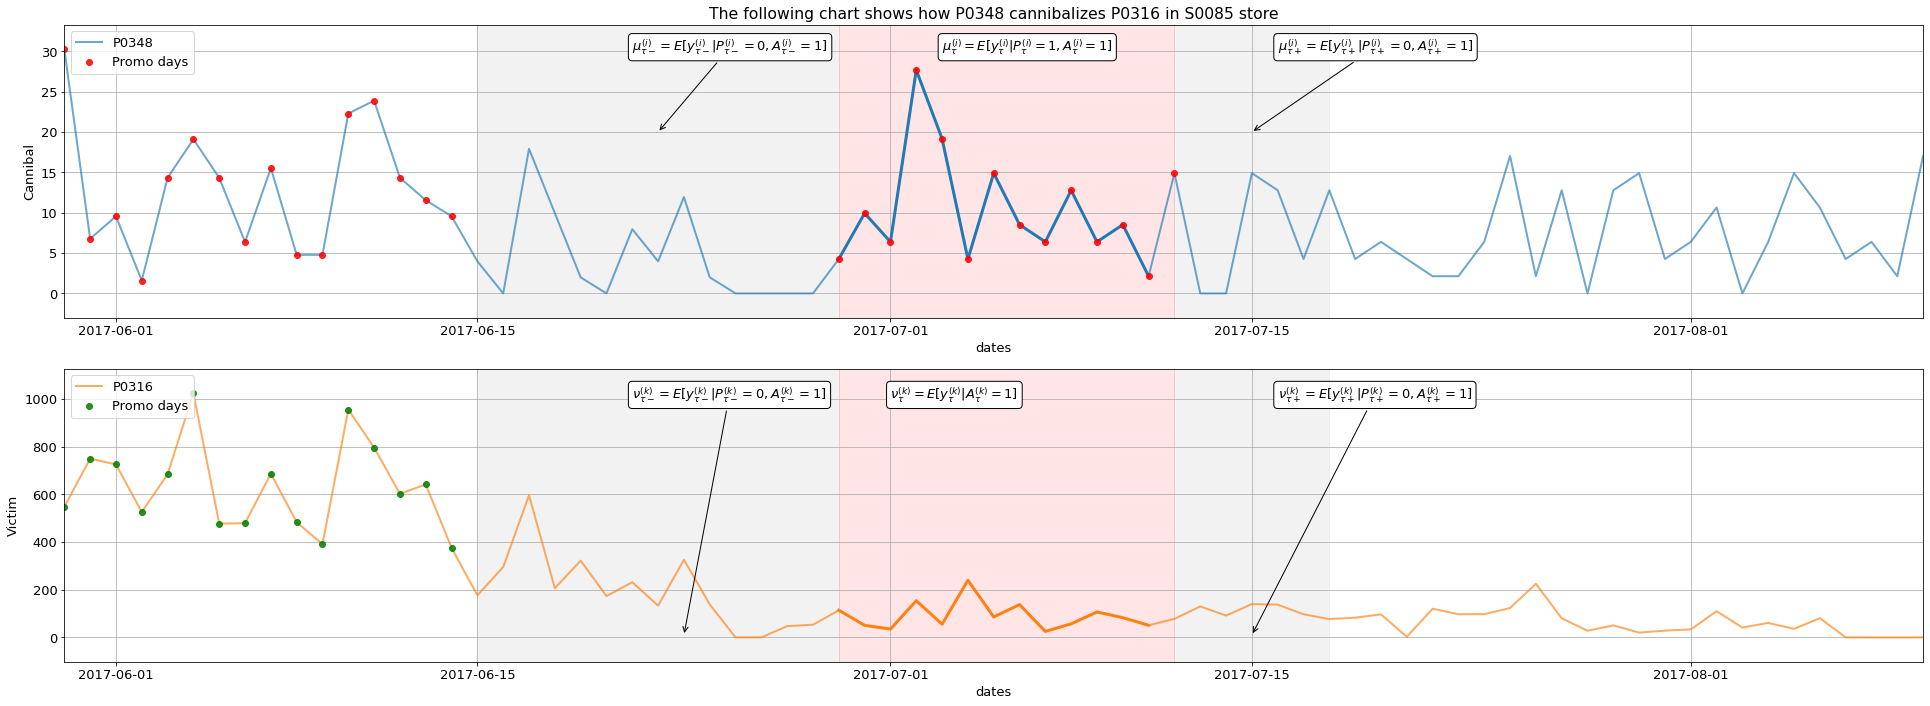

In [86]:
store_id = 'S0085'
product_id_A = 'P0348'
product_id_B = 'P0316'

df_CI = df_CI_analysis[
    (df_CI_analysis["store_id"]==store_id) &
    (df_CI_analysis["product_id_A"]==product_id_A) &
    (df_CI_analysis["product_id_B"]==product_id_B)
]
df_CI.reset_index(drop=True, inplace=True)

# Plot one store
fig, ax = plt.subplots(2,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))

df_sales_sub = df_sales_pivot[df_sales_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
df_promo_sub = df_promotion_pivot[df_promotion_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
sales_sku_A = df_sales_sub[product_id_A]
sales_sku_B = df_sales_sub[product_id_B]
promo_sku_A = df_promo_sub[product_id_A]
promo_sku_B = df_promo_sub[product_id_B]

total_days = sales_sku_A.shape[0]
num_days = sales_sku_A.index

start_period = df_CI.idx_promo_days[0][0]
end_period = df_CI.idx_promo_days[0][1]
start_period_loc = num_days.get_loc(start_period)
end_period_loc = num_days.get_loc(end_period)

xaxis_offset = 30
start_plot = start_period_loc - xaxis_offset
end_plot = end_period_loc + xaxis_offset

sku_B_reg = df_CI['sku_B_regular_avg_sales'][0]
sku_B_cannibalised = df_CI['sku_B_avg_sales_during_promo_sku_A'][0]
sku_B_predicted = df_CI['avg_predicted'][0]

slot_number = df_CI['slot_number'][0]

x_axis = num_days

idx_store = 0
idx_axis = 0

ax[0].plot(x_axis[start_plot:end_plot], sales_sku_A[start_plot:end_plot], label=f'{product_id_A}', color=def_colours[idx_store], linewidth=2, alpha=0.65)

ax[1].plot(x_axis[start_plot:end_plot], sales_sku_B[start_plot:end_plot], label=f'{product_id_B}', color=def_colours[idx_store+1], linewidth=2, alpha=0.65)

ax[0].plot(x_axis[start_period_loc:end_period_loc], sales_sku_A[start_period_loc:end_period_loc], color=def_colours[idx_store], linewidth=3, alpha=0.95)

ax[1].plot(x_axis[start_period_loc:end_period_loc], sales_sku_B[start_period_loc:end_period_loc], color=def_colours[idx_store+1], linewidth=3, alpha=0.95)

ax[0].axvspan(start_period, end_period, alpha=0.1, color='red')
ax[1].axvspan(start_period, end_period, alpha=0.1, color='red')

# Work out promo A days
mask_sku_A = np.zeros(total_days, dtype=bool)
mask_sku_A[start_plot:end_plot+1]=True

masked_promo_A = promo_sku_A & mask_sku_A
ax[0].plot(x_axis[masked_promo_A], sales_sku_A[masked_promo_A], 'o', label=f'Promo days', color='r', linewidth=2.5, alpha=0.85)


mask_sku_B = np.zeros(total_days, dtype=bool)
mask_sku_B[start_plot:end_plot+1]=True

masked_promo_B = promo_sku_B & mask_sku_B
ax[1].plot(x_axis[masked_promo_B], sales_sku_B[masked_promo_B], 'o', label=f'Promo days', color='g', linewidth=2.5, alpha=0.85)


# Add regular days
start_period_regular = df_CI.idx_regular_days[0][0]
end_period_regular = df_CI.idx_regular_days[0][1]
start_period_regular_loc = num_days.get_loc(start_period_regular)
end_period_regular_loc = num_days.get_loc(end_period_regular)
end_period_regular = num_days[end_period_regular_loc+1]

max_span = max(start_period_regular, x_axis[start_plot])
max_span_loc = num_days.get_loc(max_span)
ax[0].axvspan(max_span, end_period_regular, alpha=0.1, color='grey')


start_post_period_regular = end_period_loc
end_post_period_regular = end_period_loc + 6

ax[0].axvspan(x_axis[start_post_period_regular], x_axis[end_post_period_regular], alpha=0.1, color='grey')

ax[1].axvspan(max_span, end_period_regular, alpha=0.1, color='grey')
ax[1].axvspan(x_axis[start_post_period_regular], x_axis[end_post_period_regular], alpha=0.1, color='grey')


ax[0].legend(loc='upper left')
ax[0].set_xlabel('dates')
ax[0].set_ylabel('Cannibal')
ax[0].grid(True)
ax[0].margins(0,0.1)


ax[1].legend(loc='upper left')
ax[1].set_xlabel('dates')
ax[1].set_ylabel('Victim')
ax[1].grid(True)
ax[1].margins(0,0.1)


cannibal_yloc = 30
# Annotation of the cannibal's promotion 
xy_text = (x_axis[start_period_loc+4], cannibal_yloc)
annotation_string = r'$\mu_{\tau}^{(i)}=E[y_{\tau}^{(i)}|P_{\tau}^{(i)}=1, A_{\tau}^{(i)}=1]$'
ax[0].annotate(annotation_string, xy=(x_axis[start_period_loc-3], 30), xycoords='data', xytext=xy_text, textcoords='data', bbox=dict(boxstyle='round', fc='w'))


# Plot the formula on the regular left side
arrow_mid_point = start_period_regular_loc + round((end_period_regular_loc+1-start_period_regular_loc)/2)
xy_arrow = (x_axis[arrow_mid_point], 20)
xy_text = (x_axis[max_span_loc+6], cannibal_yloc)
annotation_string_reg = r'$\mu_{\tau-}^{(i)}=E[y_{\tau-}^{(i)}|P_{\tau-}^{(i)}=0, A_{\tau-}^{(i)}=1]$' #,C_{\tau-}^{(i)}=0
box_style = dict(boxstyle='round', fc='w')
arrow_props=dict(arrowstyle="->",connectionstyle="arc3")
ax[0].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Plot the formula on the regular right side
xy_arrow = (x_axis[end_period_loc+3], 20)
xy_text = (x_axis[start_post_period_regular+4], cannibal_yloc)
annotation_string_reg = r'$\mu_{\tau+}^{(i)}=E[y_{\tau+}^{(i)}|P_{\tau+}^{(i)}=0, A_{\tau+}^{(i)}=1]$' #,C_{\tau+}^{(i)}=0
box_style = dict(boxstyle='round', fc='w')
ax[0].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


victim_yloc = 1000
# Plot the formula on the victim's regular left side
xy_arrow = (x_axis[arrow_mid_point+1], 10)
xy_text = (x_axis[max_span_loc+6], victim_yloc)
annotation_string_reg = r'$\nu_{\tau-}^{(k)}=E[y_{\tau-}^{(k)}|P_{\tau-}^{(k)}=0, A_{\tau-}^{(k)}=1]$' #,C_{\tau-}^{(k)}=0
box_style = dict(boxstyle='round', fc='w')
arrow_props=dict(arrowstyle="->",connectionstyle="arc3")
ax[1].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Plot the formula on the victim's regular right side
xy_arrow = (x_axis[end_period_loc+3], 10)
xy_text = (x_axis[start_post_period_regular+4], victim_yloc)
annotation_string_reg = r'$\nu_{\tau+}^{(k)}=E[y_{\tau+}^{(k)}|P_{\tau+}^{(k)}=0, A_{\tau+}^{(k)}=1]$' #,C_{\tau+}^{(k)}=0
box_style = dict(boxstyle='round', fc='w')
ax[1].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Victim's
xy_text = (x_axis[start_period_loc+2], victim_yloc)
annotation_string = r'$\nu_{\tau}^{(k)}=E[y_{\tau}^{(k)}| A_{\tau}^{(k)}=1]$'
ax[1].annotate(annotation_string, xy=(x_axis[start_period_loc-3], 10), xycoords='data', xytext=xy_text, textcoords='data', bbox=dict(boxstyle='round', fc='w'))


ax[0].set_title(f"The following chart shows how {product_id_A} cannibalizes {product_id_B} in {store_id} store")
fig.tight_layout()

The cannibalization is more meaningful when the cannibals and victims are in the same closer categories.\
There are 5 levels of product hierarchy, and definitely the cannibals and victims are in the same hierarchy level 1.\
Let's see what if we narrow the level of hierarchy!

In [93]:
hierarchy_levels = ['hierarchy1_id','hierarchy2_id','hierarchy3_id','hierarchy4_id','hierarchy5_id']
df_CI_hierarchy_narrow = df_CI_analysis\
    .query(f"prob_causal_effect >= {min_prob}")\
    .reindex(columns=["store_id","product_id_A","product_id_B","prob_causal_effect","diff_in_units_from_reg_to_promo","diff_in_units_from_promo_to_pos_promo"])\
    .merge(product_hierarchy[["product_id"]+hierarchy_levels].rename(columns=lambda x: x+'_A'))\
    .merge(product_hierarchy[["product_id"]+hierarchy_levels].rename(columns=lambda x: x+'_B'))

In [99]:
for level in hierarchy_levels:
    print(level, end=": ")
    temp = df_CI_hierarchy_narrow[df_CI_hierarchy_narrow[level+"_A"]==df_CI_hierarchy_narrow[level+"_B"]]
    remain_cases = temp.shape[0]
    remain_stores = temp["store_id"].nunique()
    remain_cannibals = temp["product_id_A"].nunique()
    remain_victims = temp["product_id_B"].nunique()
    if level == 'hierarchy1_id':
        total_cases = remain_cases

    print(remain_cases, "cases (", "{:.2f}".format(100 * remain_cases / total_cases), "% ),", remain_stores, "stores,", remain_cannibals, "cannibals,", remain_victims, "victims.")

hierarchy1_id: 3109 cases ( 100.00 % ), 117 stores, 136 cannibals, 224 victims.
hierarchy2_id: 693 cases ( 22.29 % ), 72 stores, 95 cannibals, 147 victims.
hierarchy3_id: 173 cases ( 5.56 % ), 48 stores, 43 cannibals, 66 victims.
hierarchy4_id: 110 cases ( 3.54 % ), 38 stores, 29 cannibals, 41 victims.
hierarchy5_id: 55 cases ( 1.77 % ), 27 stores, 16 cannibals, 17 victims.


Visualize the cannibalization relationships
There are two ways:
- using `NetworkX`
- using `pyvis`: save as html file in data folder, more precisely and easier for viewing

In [109]:
# let see which store has the most number of cannibalization cases which the cannibals and victims are in the same hierarchy3_id
top_stores_with_cases = df_CI_hierarchy_narrow.query("hierarchy3_id_A == hierarchy3_id_B")["store_id"].value_counts()
store_id_with_most_cases = top_stores_with_cases.index[0]
top_stores_with_cases.head(10)

S0085    25
S0026    19
S0062    16
S0115    13
S0001     8
S0038     7
S0020     7
S0104     5
S0002     5
S0097     4
Name: store_id, dtype: int64

(497, 21)
./data/cannibalization_network.html


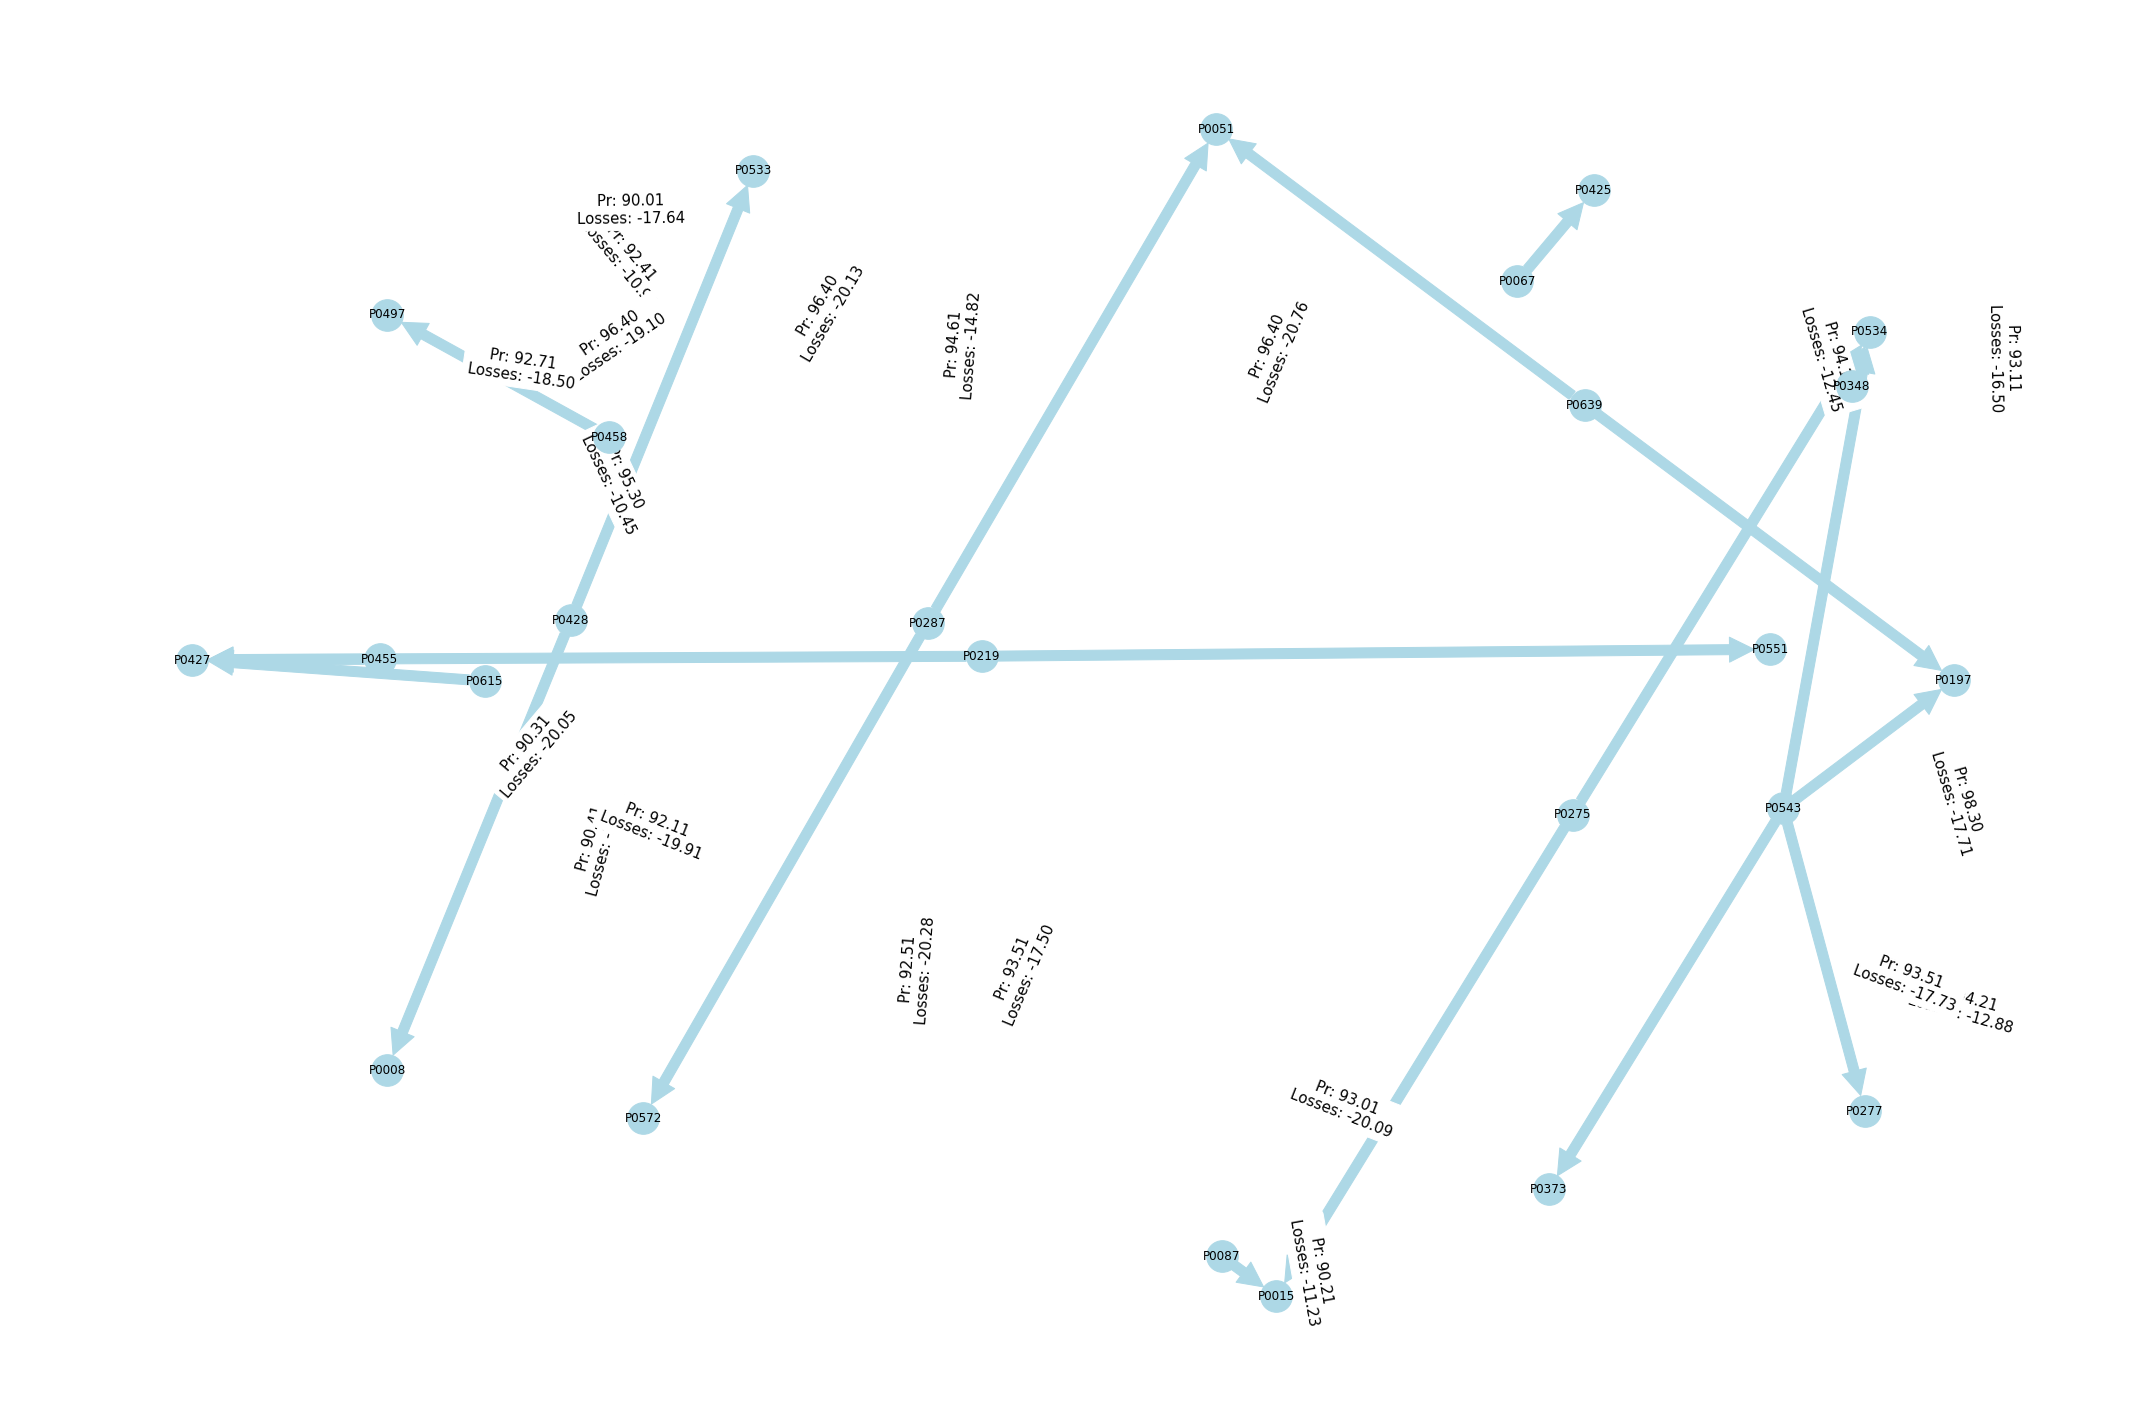

In [114]:
idx_A = df_CI_analysis.prob_causal_effect >= min_prob
df_CI_analysis_paper = df_CI_analysis[
    (df_CI_analysis.prob_causal_effect >= min_prob) & 
    (df_CI_analysis.store_id == store_id_with_most_cases)
]
df_CI_analysis_paper.sort_values("prob_causal_effect", ascending=False, inplace=True)
df_CI_analysis_paper.drop_duplicates(subset=['product_id_A','product_id_B'], keep='first', inplace=True, ignore_index=True)
df_CI_analysis_paper.sort_values(by=['cum_abs_effect'], ascending=False, inplace=True)
print(df_CI_analysis_paper.shape)

max_episodes = 20

fig_h_graph = 20
fig_w_graph = 30

edge_font_size = 15

fig, ax = plt.subplots(1,1,figsize=(fig_w_graph,fig_h_graph))
text_offset = 0
DG = nx.DiGraph()


df_CI_to_analyse = df_CI_analysis_paper[0:max_episodes].copy()
df_CI_to_analyse.rename(columns={'prob_causal_effect': 'Pr', 'cum_abs_effect': 'Losses'}, inplace=True)
vars_edges = ['Pr', 'Losses']

for item_id, df_row in df_CI_to_analyse.iterrows():
    node_A = {'name': df_row.product_id_A, 'properties': dict()}
    node_B = {'name': df_row.product_id_B, 'properties': dict()}

    edge_properties = df_row[vars_edges].to_dict()

    DG.add_node(node_A['name'], **node_A['properties'])

    DG.add_node(node_B['name'], **node_B['properties'])

    edge_label = '\n'.join([f'{k}: {v:3.2f}' for k,v in edge_properties.items()])
    DG.add_edge(node_A['name'], node_B['name'], **edge_properties, label=edge_label)

nx.draw(DG,
    node_color='lightblue',
    linewidths=1.0, 
    node_size=1000,
    with_labels=True, 
    edge_color='lightblue', 
    arrowsize=50,
    arrowstyle='simple')

labels = nx.get_edge_attributes(DG, 'label')
pos = nx.spring_layout(DG)
nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels, font_size=edge_font_size)

net = Network(notebook=True)
net.from_nx(DG)
net.show('./data/cannibalization_network.html')
plt.tight_layout()

### `STAGE 6`: Conclusion

This analysis aims to determine which products are victims during the cannibals promotion intervention. The cannibalization is not bad in all cases. In spite of victims revenue decreases, the positive total revenue (including cannibals and victims) growth makes sense to be good.

In [129]:
def sales_pivot_filter(sales_pivot:pd.DataFrame, store_id:str, date_limits:list):
    return sales_pivot[
            (sales_pivot.index.get_level_values(0)==store_id) &
            (sales_pivot.index.get_level_values(1)>=date_limits[0]) &
            (sales_pivot.index.get_level_values(1)<=date_limits[1])
        ]

df_CI_both_growth =  df_CI_analysis[df_CI_analysis["prob_causal_effect"] >= min_prob]\
    .assign(
        avg_regular_both_revenue = lambda df: df.apply(lambda x: sales_pivot_filter(df_sales_pivot, x.store_id, x.idx_regular_days)[[x.product_id_A,x.product_id_B]].sum(axis=1).mean(), axis=1),
        avg_promo_both_revenue = lambda df: df.apply(lambda x: sales_pivot_filter(df_sales_pivot, x.store_id, x.idx_promo_days)[[x.product_id_A,x.product_id_B]].sum(axis=1).mean(), axis=1),
        both_revenue_growth = lambda df: (df.avg_promo_both_revenue - df.avg_regular_both_revenue) / df.avg_regular_both_revenue
    )

In [133]:
# 1718 (> 50%) cannibalization cases bring the positive total (cannibal + victim) revenue growth
(df_CI_both_growth.both_revenue_growth > 0).value_counts()

True     1718
False    1391
Name: both_revenue_growth, dtype: int64